In [1]:
# Vorgehen in diesem Notebook:
#     Versuch eine eigene Loss Funktion zu schreiben
#     Model mit eigener negloglik (2 output units) sowie basic MSE (1 output unit)
#     durchlaufen lassen und schauen wie Predictions sich ändern im Vergleich zu 
#     Architektur mit Tensorflow Probability

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
% cd gdrive/MyDrive/project_sp/drnn

/content/gdrive/MyDrive/project_sp/drnn


In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
import time

In [5]:
# load custom modules
from utils import plot, run_training
from model_tf import DDR_MLP_basic

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
# Ausgeben ob mit GPU gibt
tf.debugging.set_log_device_placement(False)  #
# RAM für Berechnungen beschränken
physical_devices = tf.config.list_physical_devices("GPU")
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.set_floatx("float64")

Num GPUs Available:  0


In [7]:
#location of simulated dataset (standardized version)
datapath = pathlib.Path('../simdata_norm.csv')

In [8]:
dataset = pd.read_csv(datapath) #load data
data = dataset.sample(frac=1) # shuffle data just in case

In [9]:
N = len(dataset.index)
# number of epochs to train the model for
num_epochs = 30
# how many variables
input_units = 11
# define batch size for training
batch_size = 256
# maximum number of hidden units for random search
max_hidden_units = 500
# learning rate
lr = 0.001
# number hidden layers
num_hidden_layers = 3

In [9]:
#####  MODEL (REMOVE AND MOVE INTO MODULE AT LATER TIME)###########
class DDR_MLP_basic(tf.keras.Model):
  def __init__(self, num_hidden_layers, num_hidden_units, activation_fun = "relu", 
    output_units = 2):

    super(DDR_MLP_basic, self).__init__()
    self.num_hidden_layers = num_hidden_layers
    self.num_hidden_units = num_hidden_units
    self.act_fun = activation_fun


    #check for valid combination of hidden unit list and number of hidden layers
    if isinstance(self.num_hidden_units, int):
      self.num_hidden_units = np.full(self.num_hidden_layers, self.num_hidden_units)
    elif self.num_hidden_layers > len(self.num_hidden_units):
      raise ValueError("not enough values of hidden units supplied") 


    ##### model architecture #####
    #setup and input layer
    self.arch = tf.keras.Sequential()
    self.arch.add(tf.keras.layers.InputLayer(input_shape=(11)))

    #add hidden layers
    for i in range(self.num_hidden_layers):
      self.arch.add(tf.keras.layers.Dense(self.num_hidden_units[i], activation='relu'))

    #output layers
    self.arch.add(tf.keras.layers.Dense(output_units)) #no activation function in last layer

  def call(self, inputs):
    x = self.arch(inputs)
    return tf.cast(x, dtype = tf.float64)

In [10]:
## Data Split nach: 80/20
# 80% als Train und validation:
train = data[0 : int(len(data) * 0.8)]
# 20% als Testing:
test = data[int(len(data) * 0.8) : int(len(data))]

# Sicherheitshalber x und y aufteilung nachbauen.
x_train = train.iloc[:, 0:11]
y_train = train.iloc[:, 11]
x_test = test.iloc[:, 0:11]
y_test = test.iloc[:, 11]

# Umformen in TensorFlow Tensoren aus Verlässlichkeit
# Train:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
# Test
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

In [90]:
################Loss Functions##################
def negloglik(y_true, y_pred):
  N = len(y_true)

  #split y_pred into mu and sigma,
  #change dtype to float64
  mu_pred = tf.cast(y_pred[:, 0], dtype = tf.float64)
  tmp = tf.cast(y_pred[:, 1], dtype = tf.float64)

  #sigma_pred needs to be fed though exp() to fulfill parameter space
  #constraints (ie needs to be positive)
  ###TODO: check whether this is okay here or if it should be moved INTO the model
  sigma_pred = tf.math.exp(tmp) 

  return y_pred
  '''formula negloglik: ((1/2)*log(2*pi)) + log(sigma_pred) + 
                      0.5 * ((y_true - mu_pred)**2 / (sigma_pred**2))
  and now in tf.math expressions yay'''

  tmp = (1/2) * tf.math.log(2 * np.pi)
  offset = tf.cast(tf.repeat(tmp, N), dtype = tf.float64)
  first_term = tf.math.log(sigma_pred)

  error_term = tf.math.square(tf.math.subtract(y_true, mu_pred))
  variance = tf.math.square(sigma_pred)
  second_term = tf.math.scalar_mul(0.5, tf.math.divide(error_term, variance))


  all_terms = tf.math.add(offset, tf.math.add(first_term, second_term))
  return tf.reduce_sum(all_terms)

# Fit with negloglik as Loss


In [81]:
optim = tf.optimizers.Adam
model = DDR_MLP_basic(3, 10, output_units=2)
model.compile(optimizer = optim(learning_rate = 0.001),
              loss = negloglik,
              metrics = [tf.keras.metrics.MeanSquaredError()])

In [82]:
mfit_history = model.fit(x = x_train, y = y_train, 
                        batch_size = batch_size,
                        epochs = 50, verbose=False, 
                        validation_split = 0.25)

In [85]:
#why the f*** are these not the same?
negloglik(y_train, model.predict(x_train)).numpy(), mfit_history.history['loss'][len(mfit_history.history['loss'])-1]

(array([-0.01077206, -0.01005454, -0.00869512, ..., -0.01634323,
        -0.01543061, -0.0108812 ]), -32750.769529947916)

In [92]:
negloglik(y_train, model.predict(x_train)).shape

(8000, 2)

Model does not seem to be actually optimizing the negloglik?? Have to explore this some more.
-> From some forum: Possible explanation? .evaluate() will do an average of the metric across batches of batch_size, while predict will run predictions then your loss is computed over the whole array. This is quite a change in your case because average(f1(batch)) is quite different from f1(all_data).

But first, let's look at the loss curves.

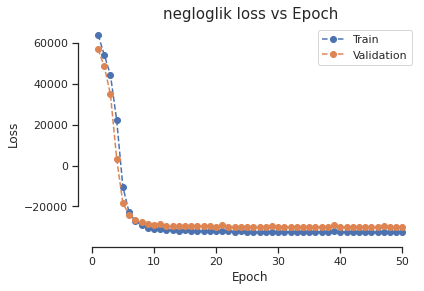

In [78]:
plot("negloglik loss vs Epoch", "Loss", mfit_history.history['loss'], mfit_history.history['val_loss'])

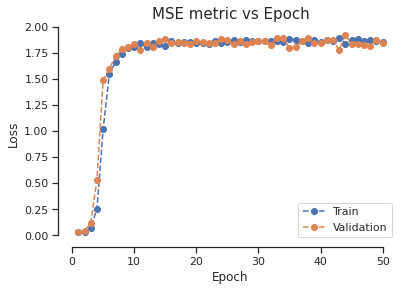

In [79]:
plot("MSE metric vs Epoch", "Loss", mfit_history.history['mean_squared_error'], mfit_history.history['val_mean_squared_error'])

Text(0.5, 1.0, 'True Values')

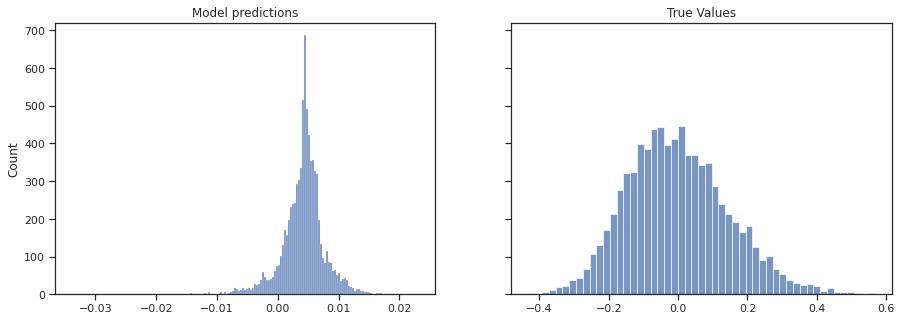

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = model(x_train)[:,0])
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train)
axes[1].set_title('True Values')

# Fit with MSE as loss

In [61]:
optim = tf.optimizers.Adam
model = DDR_MLP_basic(3, 10, output_units=1) #only one output unit (leaving out the variance)
model.compile(optimizer = optim(learning_rate = 0.001),
              loss = tf.keras.losses.MSE)

In [62]:
mfit_history = model.fit(x = x_train, y = y_train, 
                        batch_size = batch_size,
                        epochs = 100, verbose=False, 
                        validation_split = 0.25)

In [68]:
#check whether mse on model predictions is the same as in history:
tf.keras.losses.MSE(y_train, tf.squeeze(model(x_train))), tf.keras.losses.MSE(y_train, tf.squeeze(model.predict(x_train))) #second one using model.predict()

(<tf.Tensor: shape=(), dtype=float64, numpy=0.014409924193055677>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.014409924193055677>)

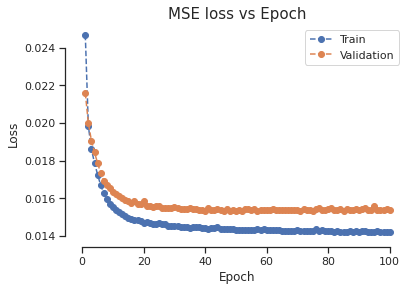

In [39]:
plot("MSE loss vs Epoch", "Loss", mfit_history.history['loss'], mfit_history.history['val_loss'])

Text(0.5, 1.0, 'True Values')

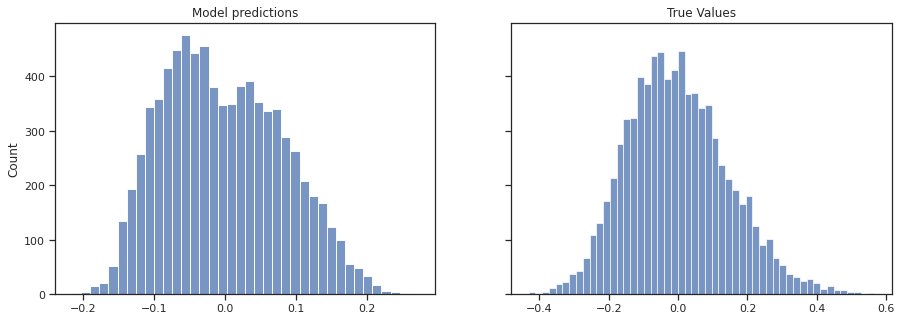

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = model(x_train)[:,0])
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train)
axes[1].set_title('True Values')

Here, the model seems to be working fine. We even see some light overfitting after like 40 epochs.